## 决策树
决策树是多功能的机器学习算法，可以执行分类和回归任务，甚至可以执行多输出任务。它们是功能强大的算法，能够拟合复杂的数据集。例如，在加州房屋数据集中训练了DecisionTreeRegressor模型，使其完全拟合（实际上是过拟合）。

决策树也是随机森林的基本组成部分，它们是当今最强大的机器学习算法之一。

将讨论如何使用决策树进行训练，可视化和做出预测开始。然后，将了解Scikit-Learn使用的CART训练算法，并将探索如何对树进行正则化并将其用于回归任务。最后，将讨论决策树的一些局限性。

In [27]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [28]:
# 可视化决策树，用export_graphviz() 函数输出一个图形定义文件
from sklearn.tree import export_graphviz

export_graphviz(tree_clf,
                out_file="./images/decision_tree/iris_tree.dot",
                feature_names=["petal length (cm)", "petal width (cm)"],
                class_names=iris.target_names,
                rounded=True,
                filled=True)


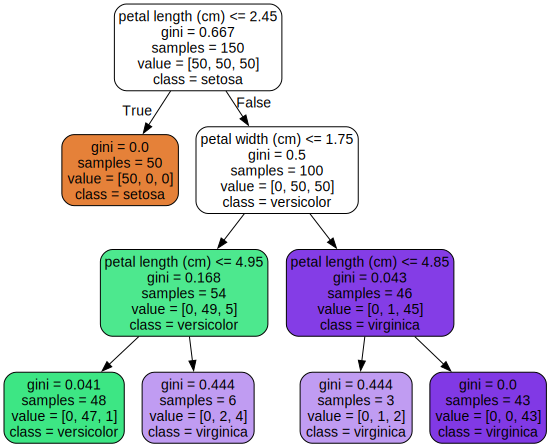

In [29]:
# 使用graphviz.Source.from_file() 加载并显示该文件
from graphviz import Source

Source.from_file("./images/decision_tree/iris_tree.dot")

找到一朵鸢尾花，并希望根据它的花瓣对其进行分类。你从根节点开始（深度0，顶部）​：该节点询问花的花瓣长度是否小于等于2.45cm。如果是，则向下移动到根的左子节点（深度1，左）。在这种情况下，它是一个叶节点（即它没有任何子节点），因此它不会提出任何问题：只需查看该节点的预测类，然后决策树就可以预测你的花朵是Setosa鸢尾花(class=setosa)。

假设找到另一朵花，这次花瓣的长度大于2.45 cm。再次从根开始，但现在向下移动到它的右子节点（深度1，右）。这不是叶节点，是拆分节点，所以又问了一个问题：花瓣宽度是否小于等于1.75cm？如果是，那么花很可能是Versicolor鸢尾花（深度2，左）。如果不是，则可能是Virginica鸢尾花（深度2，右)

决策树的特质之一就是它们几乎不需要数据准备。实际上，它们根本不需要特征缩放或居中。

b节点的samples属性统计它应用的训练实例数量。例如，有100个训练实例的花瓣长度大于2.45cm（深度1，右），其中54个花瓣宽度小于1.75cm（深度2，左）。

节点的value属性说明了该节点上每个类的训练实例数量：例如，右下节点应用在0个Setosa鸢尾花、1个Versicolor鸢尾花和45个Virginica鸢尾花实例上。

最后，节点的gini属性衡量其基尼杂质：如果应用的所有训练实例都属于同一个类，那么节点就是“纯”的(gini=0)。例如，深度1左侧节点仅应用于Setosa鸢尾花训练实例，因此它是纯的并且其基尼杂质为0。以下公式说明了第i个节点的基尼杂质Gi的计算方式。例如，深度2左侧节点，基尼杂质等于
1-(0/54)^2-(49/54)^2-(5/54)^2≈0.168。

$$
G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2
$$

在此公式中：

- $ G_i $ 是第 i 个节点的基尼杂质。
- $ p_{i,k} $ 是第  i  个节点中训练实例之间的第 k 类实例的比率。



决策树的决策边界。加粗垂直实线表示根节点（深度0）的决策边界：花瓣长度=2.45cm。因为左侧区域是纯的（只有Setosa鸢尾花），所以它不可再分。

但是右侧区域是不纯的，所以深度1右侧的节点在花瓣宽度=1.75cm处（虚线所示）再次分裂。

因为这里最大深度max_depth设置为2，所以决策树在此停止。但是如果将max_depth设置为3，那么两个深度为2的节点将各自再产生一条决策边界

![决策树的决策边界](./images/decision_tree/p1.png)

### 估计类概率
决策树同样可以估算某个实例属于特定类k的概率：首先，跟随决策树找到该实例的叶节点，然后返回该节点中类k的训练实例占比。

例如，假设发现一朵花，其花瓣长5cm，宽1.5cm。相应的叶节点为深度2左侧节点，因此决策树输出如下概率：Setosa鸢尾花，0%(0/54)；Versicolor鸢尾花，90.7%(49/54)；Virginica鸢尾花，9.3%(5/54)。

要求它预测类，那么它会输出Versicolor鸢尾花（类1），因为它的概率最大

In [25]:
tree_clf.predict_proba([[5,1.5]]).round(3)

tree_clf.predict([[5, 1.5]])

array([1])

In [26]:
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
tree_clf_deeper.predict_proba([[6,1.5]]).round(3)

array([[0.   , 0.333, 0.667]])

### CART训练算法
Scikit-Learn使用分类和回归树(Classification and Regression Tree，CART)算法来训练决策树（也称为“增长树”）。

该算法的工作原理是，首先使用单个特征k和阈值tk（例如，“花瓣长度≤2.45cm”）将训练集分为两个子集。

如何选择k和tk？它搜索产生最纯子集的一对(k，tk)，按其大小加权。以下公式给出了算法试图最小化的代价函数。

$$
J(k, t_k) = \frac{m_{\text{左}}}{m} G_{\text{左}} + \frac{m_{\text{右}}}{m} G_{\text{右}}
$$

其中：

- $ G_{\text{左/右}} $：测量左/右子集的不纯度, 可以用基尼指数衡量
- $ m_{\text{左/右}} $：测量左/右子集的实例数

一旦CART算法成功地将训练集分为两部分，它就会使用相同的逻辑将子集进行拆分，然后再拆分子子集，以此类推。一旦达到最大深度（由max_depth超参数定义），或者找不到可减少不纯度的分割，它将停止递归。其他一些超参数可以控制其他一些停止条件：min_samples_split、min_samples_leaf、min_weight_fraction_leaf和max_leaf_nodes。

bCART是一种贪心算法：从顶层开始搜索最优拆分，然后每层重复这个过程。几层拆分之后，它并不会检视这个拆分的不纯度是否为可能的最小值。贪心算法通常会产生一个相当不错的解，但是不能保证是最优解。

寻找全局最优的树需要访问所有的可能性，需要O(exp(m))时间，即使小训练集也需要花费很多时间，所以训练决策树满足于“不错”的解决方案。

### 计算复杂度
进行预测需要从根到叶遍历决策树。决策树通常是近似平衡的，因此遍历决策树需要经过大约 O($ log_2(m)$)  个节点，其中 $ log_2(m) $ 是 m 的二进制对数，等于 log(m)/log(2)。由于每个节点仅需检查一个特征值，因此总体预测复杂度为 O($log_2(m)$)，与特征数量无关。因此，即使处理大训练集，预测也非常快。

训练算法比较每个节点上所有样本上的所有特征值（如果设置了 `max_features`，则更少）。比较每个节点上所有样本的所有特征会导致训练复杂度为 $ O(n \times m \log_2(m)) $。


### 基尼杂质或熵

默认情况下，DecisionTreeClassifier类使用基尼杂质来度量，但是，可以将超参数criterion设置为"entropy"来选择信息熵作为杂质的测量方式。

熵是衡量一个节点中数据混杂程度的指标。如果一个节点中的样本全部属于同一类，那么熵为 0，表示纯度最高；如果样本被多个类均匀分布，则熵较高，表示更混杂。

例如，某个节点中共有 54 个样本，其中 49 个是正类，5 个是负类，则该节点的熵为：

$$
H_i = -\frac{49}{54} \log_2\left(\frac{49}{54}\right) - \frac{5}{54} \log_2\left(\frac{5}{54}\right) \approx 0.445
$$

这个值表示该节点的样本并不是完全纯净的，存在一定的混杂程度。


熵越大，表示一个节点中的样本分布越均匀、越混杂。比如下面两个节点的对比：

- **节点 A** 中有 50 个样本，其中 49 个是正类、1 个是负类：

  $$
  H_A = -\frac{49}{50} \log_2\left(\frac{49}{50}\right) - \frac{1}{50} \log_2\left(\frac{1}{50}\right) \approx 0.081
  $$

  熵很小，说明这个节点很“纯”。

- **节点 B** 中有 50 个样本，25 个是正类，25 个是负类：

  $$
  H_B = -\frac{25}{50} \log_2\left(\frac{25}{50}\right) - \frac{25}{50} \log_2\left(\frac{25}{50}\right) = -0.5 \log_2(0.5) - 0.5 \log_2(0.5) = 1
  $$

  熵为 1，是两类最均匀的情况，表示完全混乱。

因此，在决策树中我们更倾向于选择那些**可以把数据划分为低熵子集的特征**，以提升纯度。

公式：
$$
H_i = -\sum_{\substack{k=1 \\ p_{i,k} \ne 0}}^{n} p_{i,k} \log_2(p_{i,k})
$$



那么应该使用基尼杂质还是信息熵呢？其实，大多数情况下，它们并没有什么大的不同，产生的树都很相似。基尼杂质的计算速度略微快一些，所以它是个不错的默认选择。它们的不同在于，基尼杂质倾向于从树枝中分裂出最常见的类，而信息熵则倾向于生成更平衡的树

### 正则化超参数

决策树极少对训练数据做出假设（比如线性模型就正好相反，它显然假设数据是线性的）。如果不加以限制，树的结构将跟随训练集变化，严密拟合，并且很可能过拟合。

这种模型通常被称为非参数模型，这不是说它不包含任何参数（事实上它通常有很多参数），而是指在训练之前没有确定参数的数量，导致模型结构自由而紧密地贴近数据。

相应的参数模型，比如线性模型，则有预先设定好的一部分参数，因此其自由度受限，从而降低了过拟合的风险（但是增加了欠拟合的风险）。

为避免过拟合，需要在训练过程中降低决策树的自由度（正则化）。正则化超参数的选择取决于你所使用的模型，但是通常来说，至少可以限制决策树的最大深度。在Scikit-Learn中，这由超参数max_depth控制，默认值为None，意味着无限制。减小max_depth可使模型正则化，从而降低过拟合的风险。

DecisionTreeClassifier类有一些其他参数类似地限制决策树的形状：

- max_features: 为在每个节点处进行拆分而评估的最大特征数
- max_leaf_nodes: 最大叶节点数
- min_samples_split: 一个节点在拆分之前必须拥有的最小样本数
- min_samples_leaf: 必须创建叶节点的最小样本数
- min_weight_fraction_leaf: 与min_samples_leaf相同效果，但表示为加权实例总数的一小部分 （这个参数主要用于加权决策树，也就是说，每个样本不仅仅是“1票”，而是可能有不同的权重（weight））

增加min_*,或者减少max_*超参数将使模型正则化

In [30]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [33]:
# 非正则化的模型明显过拟合，正则化后的树泛化得更好
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)
tree_clf2.score(X_moons_test, y_moons_test)

0.92